**Importing all needed libraries**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import random
import pickle
import yfinance as yf
import math




**Importing the stock historical data using yfinance library**

In [4]:
stock = "AAPL"
stock_data = yf.Ticker(stock)
stock_data = stock_data.history(period="max")
stock_data.index = stock_data.index.date

stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1980-12-12,0.099874,0.100308,0.099874,0.099874,469033600,0.0,0.0
1980-12-15,0.095098,0.095098,0.094663,0.094663,175884800,0.0,0.0
1980-12-16,0.088149,0.088149,0.087715,0.087715,105728000,0.0,0.0
1980-12-17,0.089886,0.090320,0.089886,0.089886,86441600,0.0,0.0
1980-12-18,0.092492,0.092927,0.092492,0.092492,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2022-11-30,141.399994,148.720001,140.550003,148.029999,111224400,0.0,0.0
2022-12-01,148.210007,149.130005,146.610001,148.309998,71250400,0.0,0.0
2022-12-02,145.960007,148.000000,145.649994,147.809998,65421400,0.0,0.0
2022-12-05,147.770004,150.919998,145.770004,146.630005,68732400,0.0,0.0


In [5]:
stock_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,10586.000000,10586.000000,10586.000000,10586.000000,1.058600e+04,10586.000000,10586.000000
mean,15.604830,15.782905,15.430142,15.613308,3.280563e+08,0.000646,0.001606
std,34.491701,34.911629,34.087054,34.516381,3.379813e+08,0.010536,0.085275
min,0.038647,0.038647,0.038213,0.038213,0.000000e+00,0.000000,0.000000
25%,0.236627,0.242348,0.231883,0.237120,1.216180e+08,0.000000,0.000000
50%,0.401293,0.407782,0.393791,0.400951,2.152136e+08,0.000000,0.000000
75%,13.833536,13.951016,13.634563,13.788423,4.072054e+08,0.000000,0.000000
max,181.576172,181.884380,178.086416,180.959747,7.421641e+09,0.230000,7.000000


**Plotting based on stock's closing price**

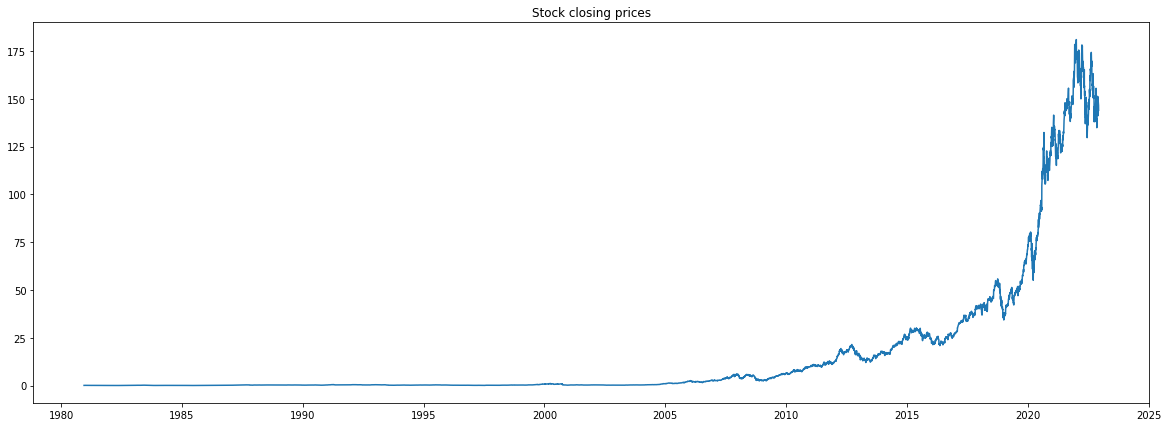

In [6]:
plt.figure(figsize=(20, 7))
plt.title('Stock closing prices')
plt.plot(stock_data['Close']) 


**Data Processing**
- Dropping irrelevant columns
- Adding new columns:
  - Exponential Moving Average (EMA) indicator.
  - Price difference for next day ( day[i] - day[i-1] )

In [7]:
stock_data_clean = stock_data.drop(['High','Open','Low','Dividends','Stock Splits'], axis=1)
stock_data_new = stock_data_clean
stock_data_new['EMA_10'] = stock_data_clean['Close'].ewm(span=10, adjust=False).mean()
stock_data_new['EMA_10'] = stock_data_clean['Close'] - stock_data_new['EMA_10']
dif = []
dif.extend(stock_data_new.Close[1:].values - stock_data_new.Close[:-1].values)
dif.append(0)
stock_data_new['dif'] = dif

stock_data_new[-1000:]

,Close,Volume,EMA_10,dif
2018-12-18,40.071682,135366000,-0.860016,-1.249897
2018-12-19,38.821785,196189200,-1.726293,-0.979656
2018-12-20,37.842129,259092000,-2.213958,-1.471897
2018-12-21,36.370232,382978400,-3.015700,-0.941040
2018-12-24,35.429192,148676800,-3.237333,2.494972
...,...,...,...,...
2022-11-30,148.029999,111224400,1.140049,0.279999
2022-12-01,148.309998,71250400,1.161857,-0.500000
2022-12-02,147.809998,65421400,0.541519,-1.179993
2022-12-05,146.630005,68732400,-0.522387,-2.650497


**Plotting the the last 1000 day**:
  - 80% training
  - 10% validation
  - 10% testing

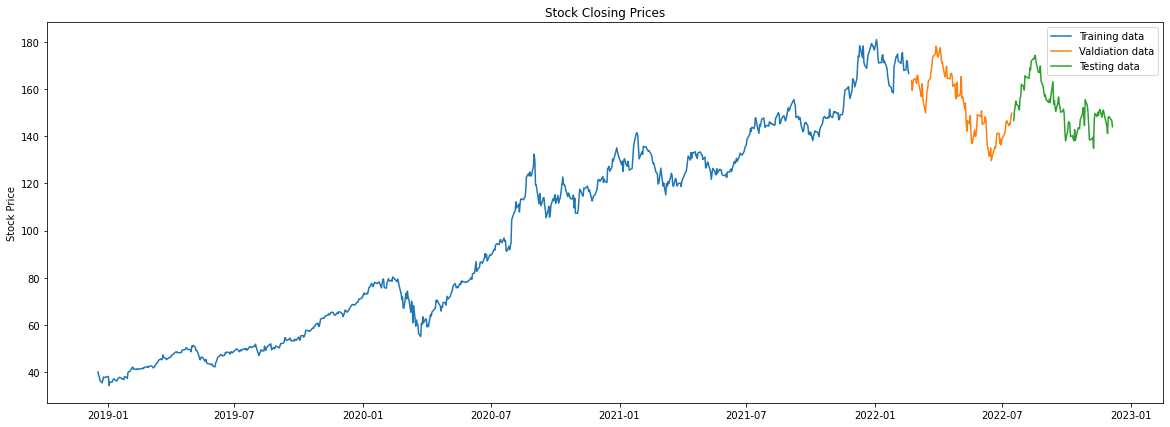

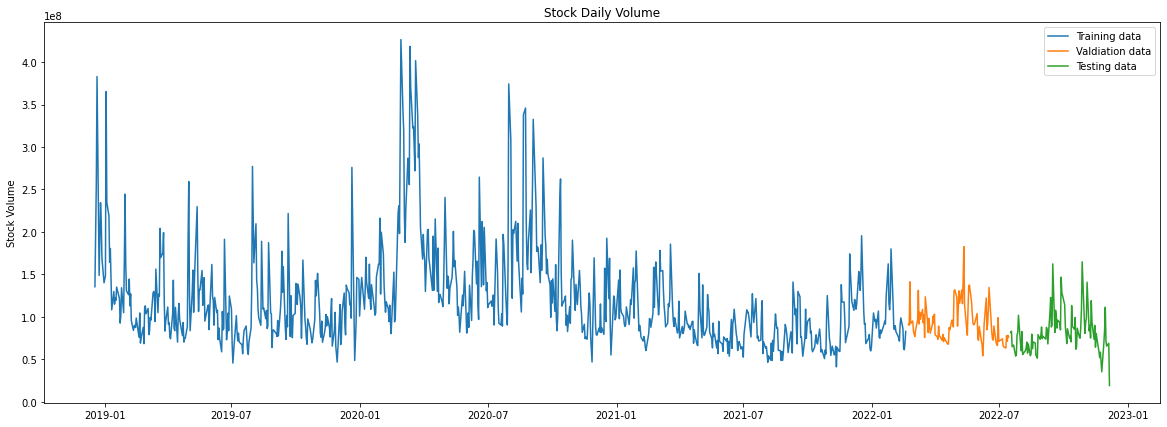

In [8]:
stock_data_clean = stock_data_clean[-1000:]
train_set =  stock_data_clean[:int(0.80 * len( stock_data_clean))]
testing_set = stock_data_clean[int(0.80 * len( stock_data_clean)):]
val_set = testing_set[:int(0.50 * len( testing_set))]
test_set = testing_set[int(0.50 * len( testing_set)):]


plt.figure(figsize=(20, 7))
plt.title('Stock Closing Prices')
plt.plot(train_set['Close'],label="Training data") 
plt.plot(val_set['Close'],label="Valdiation data") 
plt.plot(test_set['Close'],label="Testing data") 
plt.ylabel("Stock Price")
plt.legend()

plt.show()
plt.figure(figsize=(20, 7))
plt.title('Stock Daily Volume')
plt.plot(train_set['Volume'],label="Training data") 
plt.plot(val_set['Volume'],label="Valdiation data") 
plt.plot(test_set['Volume'],label="Testing data") 
plt.ylabel("Stock Volume")
plt.legend()

plt.show()

**Principal Component Analysis (PCA)**




In [9]:
#'''
scaler_data = StandardScaler()
data_scaled = scaler_data.fit_transform(stock_data_new[-1000:].values)

pca = PCA(3)  
X_pca = pca.fit_transform(data_scaled) # fit and reduce dimension
pca_df = pd.DataFrame(pca.components_, columns = stock_data_new.columns)
pca_df


,Close,Volume,EMA_10,dif
0,-0.659757,0.683023,-0.273953,0.152149
1,0.242297,-0.172911,-0.604043,0.739274
2,0.205183,0.050813,-0.729024,-0.651032


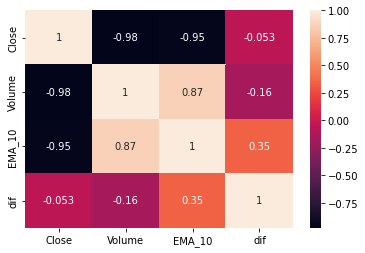

In [10]:
sns.heatmap(pca_df.corr(),annot=True)
plt.show()

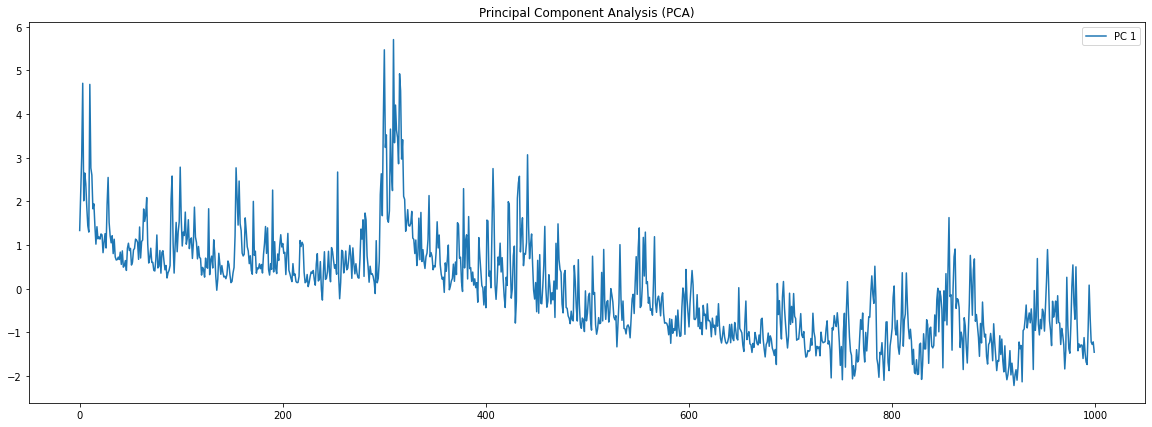

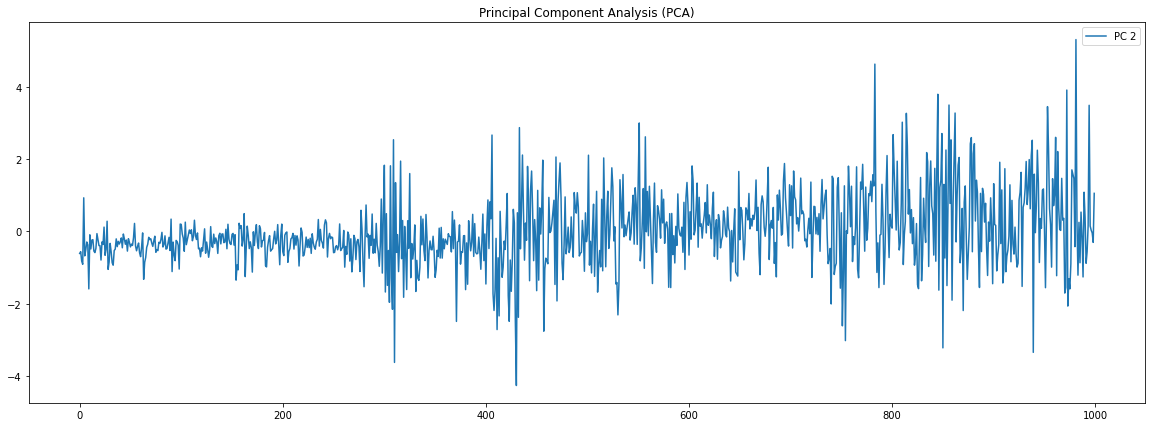

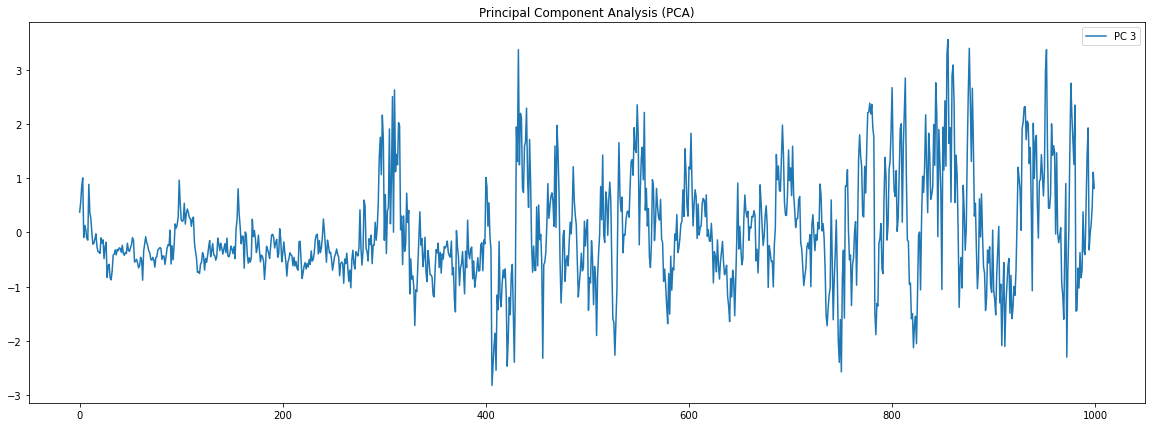

In [11]:
pc1 = [x[0] for x in X_pca]
pc2 = [x[1] for x in X_pca]
pc3 = [x[2] for x in X_pca]

plt.figure(figsize=(20, 7))
plt.title('Principal Component Analysis (PCA)')
plt.plot(pc1,label="PC 1") 
plt.legend()
plt.show()

plt.figure(figsize=(20, 7))
plt.plot(pc2,label="PC 2") 
plt.title('Principal Component Analysis (PCA)')
plt.legend()
plt.show()

plt.figure(figsize=(20, 7))
plt.plot(pc3,label="PC 3") 
plt.title('Principal Component Analysis (PCA)')
plt.legend()
plt.show()

**Normlaizing and splitting the data** \
  - 80% training
  - 10% validation
  - 10% testing

In [12]:
#'''
scaled_data = stock_data_new[-1000:].values

train_set =  scaled_data[:int(0.80 * len( scaled_data))]
testing_set = scaled_data[int(0.80 * len( scaled_data)):]
val_set = testing_set[:int(0.50 * len( testing_set))]
test_set = testing_set[int(0.50 * len( testing_set)):]

scaler_train = StandardScaler()
scaler_val = StandardScaler()
scaler_test = StandardScaler()

train_set = scaler_train.fit_transform(train_set)
val_set = scaler_val.fit_transform(val_set)
test_set = scaler_test.fit_transform(test_set)



len(train_set),len(val_set),len(test_set)
#'''

(800, 100, 100)

**Splitting the  data into learning period and lables** \
prediction/target is based on the previous period

In [13]:
learning_period = 5
training_data_A, training_data_B = [], []
  
for i in range(learning_period, len(train_set)):
  training_data_A.append(train_set[i-learning_period:i])
  training_data_B.append(train_set[i])

x_train, y_train = torch.Tensor(training_data_A), torch.Tensor(training_data_B)
print(x_train.shape, y_train.shape)

val_data_A, val_data_B = [], []
for i in range(learning_period, len(val_set)):
  val_data_A.append(val_set[i-learning_period:i])
  val_data_B.append(val_set[i])

x_val, y_val = torch.Tensor(val_data_A), torch.Tensor(val_data_B)
print(x_val.shape, y_val.shape)


test_data_A, test_data_B = [], []
for i in range(learning_period, len(test_set)):
  test_data_A.append(test_set[i-learning_period:i])
  test_data_B.append(test_set[i])

x_test, y_test = torch.Tensor(test_data_A), torch.Tensor(test_data_B)
print(x_test.shape, y_test.shape)

torch.Size([795, 5, 4]) torch.Size([795, 4])
torch.Size([95, 5, 4]) torch.Size([95, 4])
torch.Size([95, 5, 4]) torch.Size([95, 4])


<ipython-input-13-b292d48ec800>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_train, y_train = torch.Tensor(training_data_A), torch.Tensor(training_data_B)


**Step 3: Build the Transformer Model**

**Positional Encoder**

In [14]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)



**Transformer Model**

In [15]:
class Transformer(nn.Module):

    def __init__(self):
        super(Transformer, self).__init__()
        input_size = 4
        d_model = 256
        kernel_size = 6
        max_len = 7
        nhead = 8
        num_layers = 3
        output_size = 4

        self.conv = nn.Conv1d(input_size, d_model, kernel_size=kernel_size)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, output_size)
        self.kernel_size = kernel_size

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.pad(x, (self.kernel_size-1,0))
        x = self.conv(x).permute(2, 0, 1)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x).transpose(0, 1)[:, -1:]
        x = self.decoder(x.squeeze())
        return x


model = Transformer()
model

Transformer(
  (conv): Conv1d(4, 256, kernel_size=(6,), stride=(1,))
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=Tru

**Step 4: Define Loss Function**

In [16]:
loss_func = torch.nn.MSELoss()

**Step 5: Define Optimizer**

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**Function to remove selected random batch from list**

In [18]:
def sample_remove(a , b ):
  set1 = set(a)
  set2 = set(b)
  return list(set1 - set2)

**Step 6: Training Loop (including Training & Validation & save checkpoints)**

In [19]:
n_epochs = 40
batch = 16
validation_loss_min = np.Inf

for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}')
    train_loss = 0.0
    train_correct = 0

    model.train()
    index_list_train = [b for b in range(0,len(y_train)) ]
    count = 0
    for i in range(len(x_train) // batch):
        # Selecting random batchs to be used for training
        index_samples = random.sample(index_list_train,batch)
        index_list_train = sample_remove(index_list_train,index_samples)

        optimizer.zero_grad()
        output = model(x_train[index_samples])
        loss = loss_func(output,y_train[index_samples])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        count += 1
    print(f'\t training loss: {train_loss/count:.6f}')


    validation_loss = 0.0
    count = 0
    model.eval()
    index_list_eval = [b for b in range(0,len(x_val)) ]
    count = 0
    for i in range(len(x_val) // batch):
      # Selecting random batchs to be used for validation
        index_samples = random.sample(index_list_eval,batch)
        index_list_eval = sample_remove(index_list_eval,index_samples)
        output = model(x_val[index_samples])
        loss = loss_func(output, y_val[index_samples])
        validation_loss += loss.item()
        count += 1
    print(f'\t validation loss: {validation_loss/count:.6f}')

    
    if validation_loss <= validation_loss_min:
        print(f'\t validation loss decreased ({validation_loss_min/count:.6f} --> {validation_loss/count:.6f}).  Saving model ...')
        torch.save(model.state_dict(), '/content/drive/MyDrive/ColabFiles/Stock_Data/models_saved/model_testing.pt')
        validation_loss_min = validation_loss


Epoch 1
	 training loss: 1.021522
	 validation loss: 0.532818
	 validation loss decreased (inf --> 0.532818).  Saving model ...
Epoch 2
	 training loss: 0.440789
	 validation loss: 0.510334
	 validation loss decreased (0.532818 --> 0.510334).  Saving model ...
Epoch 3
	 training loss: 0.418593
	 validation loss: 0.583798
Epoch 4
	 training loss: 0.442244
	 validation loss: 0.557008
Epoch 5
	 training loss: 0.462231
	 validation loss: 0.548710
Epoch 6
	 training loss: 0.434348
	 validation loss: 0.500794
	 validation loss decreased (0.510334 --> 0.500794).  Saving model ...
Epoch 7
	 training loss: 0.420100
	 validation loss: 0.485695
	 validation loss decreased (0.500794 --> 0.485695).  Saving model ...
Epoch 8
	 training loss: 0.397426
	 validation loss: 0.482853
	 validation loss decreased (0.485695 --> 0.482853).  Saving model ...
Epoch 9
	 training loss: 0.391013
	 validation loss: 0.474141
	 validation loss decreased (0.482853 --> 0.474141).  Saving model ...
Epoch 10
	 training l

**Step 7: Select best saved model**

In [20]:
model = Transformer()
model.load_state_dict(torch.load('/content/drive/MyDrive/ColabFiles/Stock_Data/models_saved/model_testing.pt'))

<All keys matched successfully>

**Step 8: Testing (Prediction)** 

In [21]:
model.eval() 
test_pred = model(x_test)
loss = loss_func(test_pred, y_test)

print('Test Loss overall             : {:.5f}'.format(loss))

loss = loss_func(test_pred[0], y_test[0])
print('Test Loss for price prediction: {:.5f}'.format(loss))

loss = loss_func(test_pred[3], y_test[3])
print('Test Loss for price difference: {:.5f}\n'.format(loss))

Test Loss overall             : 0.50023
Test Loss for price prediction: 0.17426
Test Loss for price difference: 0.67526



**Processing test data for plotting**

In [22]:
test_pred = pd.DataFrame(scaler_test.inverse_transform(test_pred.detach().numpy()))
test_pred.index = stock_data_clean.index[-len(test_pred):]
test_y = pd.DataFrame(scaler_test.inverse_transform(y_test.detach().numpy()))
test_y.index = stock_data_clean.index[-len(test_pred):]

**Plotting actual and predicted stock closing's price**

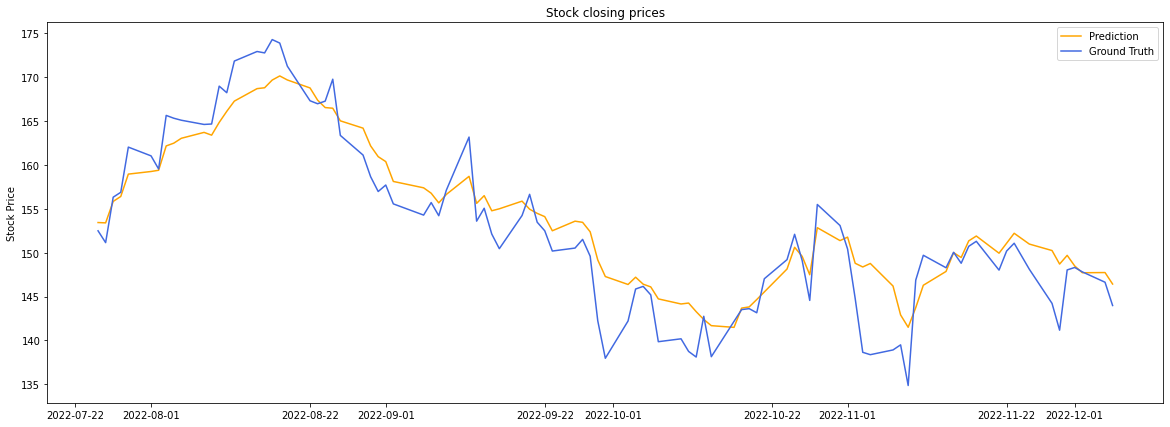

In [23]:
plt.figure(figsize=(20, 7))
plt.title('Stock closing prices')
plt.plot(test_pred[0], color='orange', label="Prediction")
plt.plot(test_y[0], color='royalblue',  label="Ground Truth")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


It can be noticed that the model seems to be more accurate in predicting the price trend in comparison to the actual price value. Therefore, I decided to do an additional metric to see, since I mostly can predict the trend, how much would that help in make profits.
The idea is, to invest if predict price of next day will increase, by using the values of the actual stock price.


**Calculating the difference of profits when investing $1000.00 using:**
- Model prediction if next day stock price will increase
- Just buying first day and profit based on last day

In [24]:
# Storing the price_change and price of predicted stock price
price_change = test_pred[0][1:].values - test_pred[0][:-1].values
price = test_pred[0][:-1].values


idx_predected_profit_days = []
# Tracking the days when expexted the price to increase
for i in range(0,len(price_change)):
  if price_change[i] > 0:
    idx_predected_profit_days.append(i)

# Calculating profits based on actual stock price using idx_predected_profit_days 


count = 1000
for i in idx_predected_profit_days:
  count = (count / test_y[0][i]) * test_y[0][i+1]
count

# Calculating the number of days when  the price increase based on actual stock price 
price_change_actual = test_y[0][1:].values - test_y[0][:-1].values
days = 0
for i in range(0,len(price_change_actual)):
  if price_change_actual[i] > 0:
    days +=1

profit_not_using = round((1000/test_y[0][0]*test_y[0][-2]),2)

print('Profit using model          = $',round(count,2))
print('Profit when not using model = $', profit_not_using)


print('Predicted increase days     = ',len(idx_predected_profit_days))
print('Actual increase days        = ', days)


Profit using model          = $ 1716.8
Profit when not using model = $ 961.6
Predicted increase days     =  43
Actual increase days        =  43


**Data saved from testing the model on several radnomly selected stocks**

In [25]:
#data = {'Stock': stock, 'Profit_model':round(count,2),'Profit_without':profit_not_using}

saved_stock_profits = pd.read_csv('/content/drive/MyDrive/ColabFiles/Stock_Data/saved_stock_profits.csv')
#saved_stock_profits = saved_stock_profits.append(data, ignore_index=True)
#saved_stock_profits.to_csv('/content/drive/MyDrive/ColabFiles/Stock_Data/saved_stock_profits.csv',index=False)


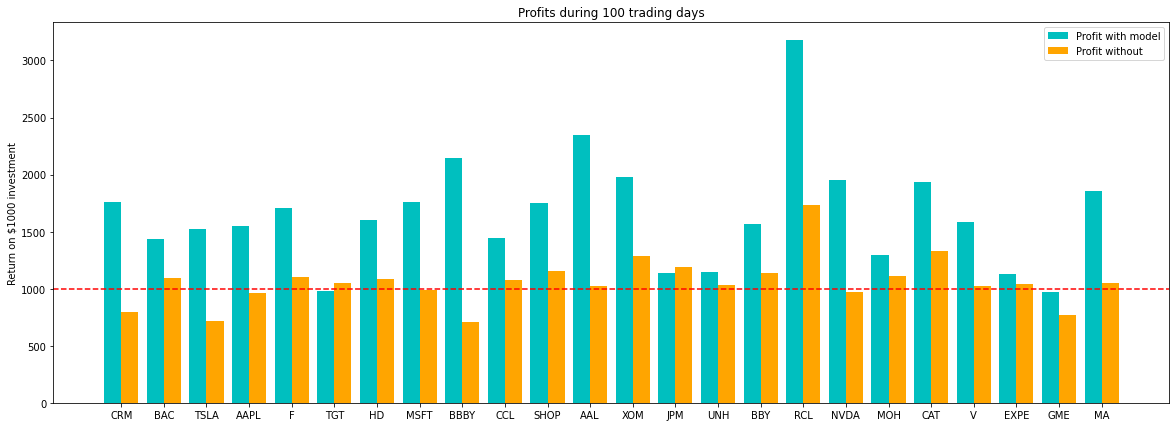

In [26]:
lenth = len(saved_stock_profits)
Profit_model = saved_stock_profits['Profit_model']
Profit_without = saved_stock_profits['Profit_without']

ind = np.arange(lenth) 
plt.figure(figsize=(20, 7))
w = 0.4     
plt.bar(ind, Profit_model, w, color='c', label='Profit with model')
plt.bar(ind + w, Profit_without, w, color='orange', label='Profit without')

plt.ylabel('Return on $1000 investment')
plt.title('Profits during 100 trading days')
plt.axhline(y=1000, color='r', linestyle='--')

plt.xticks(ind +0.2, saved_stock_profits['Stock'])
plt.legend()
plt.show()

In [27]:
saved_stock_profits

,Stock,Profit_model,Profit_without
0,CRM,1758.53,792.24
1,BAC,1435.35,1092.73
2,TSLA,1525.27,715.76
3,AAPL,1550.82,962.17
4,F,1707.17,1103.32
5,TGT,977.23,1053.79
6,HD,1599.27,1083.29
7,MSFT,1759.04,984.34
8,BBBY,2148.41,704.50
9,CCL,1444.89,1079.91
